# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/Shareddrives/OPML/20210814_Mango_identification/彥嘉

/content/drive/Shareddrives/OPML/Seminar/20210814_Mango_identification/彥嘉


In [ ]:
ls

logs/  mango.ipynb


In [ ]:
!pip install pytorch_lightning

# Import Packages

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose

In [ ]:
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# Read CSV File

In [ ]:
csv_file = pd.read_csv('../data/mango_1st_stage/train.csv')
csv_file.head(5)

,image_id,label
0,00002.jpg,C
1,00003.jpg,C
2,00004.jpg,B
3,00005.jpg,A
4,00007.jpg,A


In [ ]:
csv_file.image_id[0]

'00002.jpg'

In [ ]:
csv_file.label.unique()

array(['C', 'B', 'A'], dtype=object)

In [ ]:
len(csv_file.image_id)

5600

In [ ]:
data_root = '../data/mango_1st_stage/train'
data_path = os.path.join(data_root, csv_file.image_id[0])
image = Image.open(data_path)

(1008, 1344, 3)


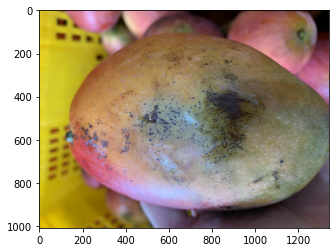

In [ ]:
array = np.array(image)
print(array.shape)
plt.imshow(image)

In [ ]:
data = {
    'image_id': csv_file.image_id[0],
    'image': os.path.join(data_root, csv_file.image_id[0]),
    'label': csv_file.label[0]
}
data

{'image': '../data/mango_1st_stage/train/00002.jpg',
 'image_id': '00002.jpg',
 'label': 'C'}

In [ ]:
a = MangoDataset(data_root, '../data/mango_1st_stage/train.csv', transform=transform )
for data in a:
    print(data)
    print(data["image"].shape)
    break

{'image': tensor([[[0.8588, 0.8431, 0.8353,  ..., 0.1373, 0.0588, 0.0157],
         [0.8549, 0.8353, 0.8235,  ..., 0.0745, 0.0157, 0.0039],
         [0.8549, 0.8392, 0.8235,  ..., 0.0196, 0.0000, 0.0039],
         ...,
         [0.8431, 0.8196, 0.8431,  ..., 0.3529, 0.3647, 0.3647],
         [0.8824, 0.8510, 0.8392,  ..., 0.3647, 0.3686, 0.3725],
         [0.8824, 0.8824, 0.8275,  ..., 0.3804, 0.3843, 0.3882]],

        [[0.7529, 0.7373, 0.7529,  ..., 0.0627, 0.0235, 0.0118],
         [0.7490, 0.7294, 0.7333,  ..., 0.0353, 0.0118, 0.0078],
         [0.7569, 0.7412, 0.7412,  ..., 0.0157, 0.0078, 0.0039],
         ...,
         [0.6980, 0.6824, 0.7176,  ..., 0.2627, 0.2745, 0.2745],
         [0.7333, 0.7098, 0.7020,  ..., 0.2784, 0.2824, 0.2824],
         [0.7333, 0.7333, 0.6784,  ..., 0.2941, 0.2902, 0.2941]],

        [[0.1373, 0.1451, 0.2039,  ..., 0.0275, 0.0039, 0.0039],
         [0.1373, 0.1294, 0.1647,  ..., 0.0078, 0.0039, 0.0000],
         [0.1412, 0.1373, 0.1490,  ..., 0.0078, 

# Load Data and Construct Dataset, DataLoader

In [ ]:
class Transform():
  def __init__(self, keys):
    self.keys = keys
    self.resize = transforms.Resize((64,64), interpolation=2)
    self.to_tensor = transforms.ToTensor()
    self.gray = transforms.Grayscale()
  
  def __call__(self, data):
    for key in self.keys:
      if key in data:
        # do yourself
        path = data[key]
        img = Image.open(path)
        # img = self.gray(img)
        rimg = self.resize(img)
        data[key] = self.to_tensor(rimg)
    
      else:
        raise KeyError(f'{key} is not a key of {data}')
    
    return data

In [ ]:
class LabelTransform():
    def __init__(self, keys):
        self.keys = keys
    def __call__(self,data):
        for key in self.keys :
            if key in data :
                c = data[key]
                if c=='A':
                    data[key] = torch.tensor(0).long()
                elif c == 'B':
                    data[key] = torch.tensor(1).long()
                else :
                    data[key] = torch.tensor(2).long()
            else :
                raise KeyError(f'{key} is not a key of {data}')
        return data


In [ ]:
transform = Compose(
    [
     Transform(keys=["image"]),
     LabelTransform(keys=['label'])
    ])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
class MangoDataset(Dataset):
  def __init__(self,data_root,csv_file,transform=None):
    super(MangoDataset, self).__init__()
    self.data_root = data_root
    self.data_list = pd.read_csv(csv_file)
    self.transform = transform
    # self.file = "{}.jpg"

  def __len__(self):
    # do yourself
    return len(self.data_list)
  
  def __getitem__(self, i):
    # do yourself
    data = {
            # "image_id": self.data_list.image_id[i],
            "image": os.path.join(self.data_root, self.data_list.image_id[i]),
            "label": self.data_list.label[i]
        }
    if self.transform is not None:
            data = self.transform(data)
    return data

In [ ]:
class MangoDataModule(LightningDataModule):
  def __init__(self , data_root = data_root, data_list = '../data/mango_1st_stage/train.csv'):
    super(MangoDataModule, self).__init__()
    # do yourself
    self.data_root = data_root
    self.data_list = data_list
  
  def prepare_data(self):
    # do yourself
    self.train_ds = MangoDataset(self.data_root, self.data_list, transform)
    self.val_ds = MangoDataset(self.data_root, self.data_list, transform)
    # return
  
  def train_dataloader(self):
    # do yourself
    return DataLoader(self.train_ds, batch_size=10)
  
  def val_dataloader(self):
    # do yourself
    return DataLoader(self.val_ds, batch_size=10)

# Model Construction

In [ ]:
class Net(LightningModule):
    def __init__(self, lr):
      super(Net, self).__init__()
      self.conv = nn.Conv2d(in_channels=3, out_channels=16, padding=1, kernel_size=3, stride=2)
      self.bn = nn.BatchNorm2d(16)
      self.prelu = nn.PReLU()
      self.dropout = nn.Dropout(p=0.5)
      self.layer  = nn.Linear(16*32*32, 3)

      self.save_hyperparameters()
      self.criterion = nn.CrossEntropyLoss()
      self.flatten = nn.Flatten()
    #   self.softmax = nn.Softmax(dim=1)

        
    def forward(self, x):
    #   self.print(x.shape)
      x = self.conv(x)
      x = self.bn(x)
    #   self.print(x.shape)
      x = self.prelu(x)
      x = self.dropout(x)
    #   self.print(x.shape)
      x = self.flatten(x)
    #   self.print(x.shape)
      x = self.layer(x)
      x = torch.sigmoid(x)
    #   self.print(x)
      
      return x
    
    
    def configure_optimizers(self):
      optimizer = Adam(self.parameters(), lr=self.hparams.lr)
      
      return optimizer
    
    
    def compute_loss(self, x, y):
      loss = self.criterion(x,y.view(-1))
      
      return loss
    
    
    def compute_acc(self, x, y):
      X = torch.argmax(x, dim=1)
      acc = torch.sum(X == y)/x.shape[0]
      self.print(f"acc = {acc}")
      self.print(f"x={x}")
      self.print(f"X={X}")
      self.print(f"y={y}")
      self.print(f"sum={torch.sum(X==y)}")
      self.print(f"shape={x.shape[0]}")
      
      return acc
    
    
    def evaluate(self, batch):
      x, y   = batch["image"],batch["label"]
    #   self.print(x)
    #   self.print(y)
    #   self.print('-'*10)
      output = self(x)
    #   self.print(y)
      loss = self.compute_loss(output, y)
    #   self.print(loss)
      acc = self.compute_acc(output, y)
          
      return {'loss': loss, 'acc': acc}
        
        
    def training_step(self, batch, batch_idx):
      output = self.evaluate(batch)

      return output
    
    
    def validation_step(self, batch, batch_idx):
      output = self.evaluate(batch)
      
      return output
    
    
    def epoch_end(self, outputs, prefix):
      meanloss = torch.mean(torch.stack([o['loss'] for o in outputs]))
      meanacc = torch.mean(torch.stack([o['acc'] for o in outputs]))
      self.log('step', self.trainer.current_epoch)
      self.log(f'{prefix}/loss', meanloss, prog_bar=prefix != "training")
      self.log('step', self.trainer.current_epoch)
      self.log(f'{prefix}/accuracy', meanacc, prog_bar=True)
      self.log('step', self.trainer.current_epoch)
      self.log(f'{prefix}/learning rate', self.hparams.lr, prog_bar=False)
      
      return None
    
    
    def training_epoch_end(self, outputs):
      self.epoch_end(outputs, "training")   
      
      return None
    
    
    def validation_epoch_end(self, outputs):
      self.epoch_end(outputs, "validation")    
      
      return None

# Setup Hyperparameters

In [ ]:
net = Net(lr=5e-4)
datamodule = MangoDataModule()

In [ ]:
cur_time = datetime.today().strftime('%Y-%m-%d-%H-%M')
os.makedirs(f"logs/mango/{cur_time}", exist_ok = True)
tensor_board_logger = TensorBoardLogger(save_dir="logs", name="mango", version=cur_time, default_hp_metric=False)
csv_logger = CSVLogger(save_dir="logs", name="mango", version=cur_time)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor="validation/accuracy",
    dirpath=f"logs/mango/{cur_time}",
    filename="{epoch:0>2}",
    save_top_k=5,
    mode="max"
)

In [ ]:
trainer = Trainer(
    max_epochs=10,
    gpus=0,
    logger=[tensor_board_logger, csv_logger],
    log_every_n_steps=1,
    weights_summary='full',
    callbacks=[checkpoint_callback],
    num_sanity_val_steps=0 
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1293: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer"


# Training

In [ ]:
a = torch.tensor([[1],[2],[3]])
a.view(-1)

tensor([1, 2, 3])

In [ ]:
trainer.fit(net, datamodule=datamodule)


  | Name      | Type             | Params
-----------------------------------------------
0 | conv      | Conv2d           | 448   
1 | bn        | BatchNorm2d      | 32    
2 | prelu     | PReLU            | 1     
3 | dropout   | Dropout          | 0     
4 | layer     | Linear           | 49.2 K
5 | criterion | CrossEntropyLoss | 0     
6 | flatten   | Flatten          | 0     
-----------------------------------------------
49.6 K    Trainable params
0         Non-trainable params
49.6 K    Total params
0.199     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

acc = 0.30000001192092896
x=tensor([[0.2386, 0.4630, 0.4768],
        [0.3161, 0.5797, 0.2705],
        [0.5415, 0.3733, 0.4009],
        [0.4635, 0.2201, 0.4457],
        [0.4512, 0.4186, 0.3641],
        [0.4764, 0.1833, 0.7758],
        [0.7106, 0.4370, 0.6259],
        [0.4317, 0.5669, 0.6655],
        [0.3235, 0.2356, 0.5789],
        [0.5139, 0.2723, 0.2583]], grad_fn=<SigmoidBackward>)
X=tensor([2, 1, 0, 0, 0, 2, 0, 2, 2, 0])
y=tensor([2, 2, 1, 0, 0, 1, 1, 0, 0, 1])
sum=3
shape=10
acc = 0.30000001192092896
x=tensor([[0.3786, 0.5621, 0.2551],
        [0.7959, 0.7703, 0.0709],
        [0.5527, 0.4328, 0.1725],
        [0.5161, 0.4277, 0.1346],
        [0.4051, 0.5418, 0.2916],
        [0.6168, 0.5654, 0.2665],
        [0.2867, 0.7137, 0.0771],
        [0.5194, 0.5976, 0.1465],
        [0.3799, 0.3423, 0.3398],
        [0.5191, 0.7372, 0.1578]], grad_fn=<SigmoidBackward>)
X=tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 1])
y=tensor([0, 0, 0, 0, 0, 1, 2, 2, 1, 2])
sum=3
shape=10
acc = 0.400000

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1047: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Tensorboard

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir logs/